# Time series forecasting with DeepAR

## ***This is using the hourly aggregated data across VMs***
DeepAR is a supervised learning algorithm for forecasting scalar time series. 


Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [256]:
bucket = 'sagemaker-testtimeseries'
prefix = 'sagemaker/test-demo-deepar'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [257]:
role

'arn:aws:iam::945416147148:role/service-role/AmazonSageMaker-ExecutionRole-20180616T095406'

Now we'll import the Python libraries we'll need.

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time
import json
import glob
import sagemaker.amazon.common as smac
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer
import boto3
import  s3fs
import  sagemaker
from sagemaker import get_execution_role

In [259]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [260]:

containers  = {
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest'
}
image_name = containers[boto3.Session().region_name]

In [261]:
role

'arn:aws:iam::945416147148:role/service-role/AmazonSageMaker-ExecutionRole-20180616T095406'

---
## Data

Let's download the data.  More information about this dataset can be found [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html).

In [262]:
#!wget http://gwa.ewi.tudelft.nl/fileadmin/pds/trace-archives/grid-workloads-archive/datasets/gwa-t-12/rnd.zip

In [263]:
#import zipfile
#with zipfile.ZipFile("rnd.zip","r") as zip_ref:
#    zip_ref.extractall("targetdir")

And take a look at it.

In [264]:
all_files = glob.glob(os.path.join('targetdir/rnd/2013-7/', "1*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, sep = ';\t') for f in all_files)
concatenated_df   = pd.concat(df_from_each_file)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [265]:
all_files = glob.glob(os.path.join('targetdir/rnd/2013-8/', "1*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
df_from_each_file = (pd.read_csv(f, sep = ';\t') for f in all_files)
concatenated_df8   = pd.concat(df_from_each_file)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [266]:
all_files = glob.glob(os.path.join('targetdir/rnd/2013-9/', "1*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, sep = ';\t') for f in all_files)
concatenated_df9   = pd.concat(df_from_each_file)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [267]:
newdat = concatenated_df.append(concatenated_df8)
newerdat = newdat.append(concatenated_df9)
concatenated_df = newerdat

## This creates the hold out set 

In [268]:
all_filesh = glob.glob(os.path.join('targetdir/rnd/2013-7/', "36*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
df_from_each_fileh = (pd.read_csv(f, sep = ';\t') for f in all_files)
concatenated_dfh   = pd.concat(df_from_each_fileh)

all_files = glob.glob(os.path.join('targetdir/rnd/2013-8/', "35*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file8h = (pd.read_csv(f, sep = ';\t') for f in all_files)
concatenated_df8h   = pd.concat(df_from_each_file8h)

all_files = glob.glob(os.path.join('targetdir/rnd/2013-9/', "35*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_fileh9h = (pd.read_csv(f, sep = ';\t') for f in all_files)
concatenated_df9h   = pd.concat(df_from_each_fileh9h)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning

In [269]:
concatenated_dfh.head()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
0,1377986608,1,2599.999343,60.666651,2.333333,2097152.0,265636.533333,1.133333,8.800000,1.8,8.000000
1,1377986908,1,2599.999343,53.733320,2.066667,2097152.0,318765.600000,0.266667,10.133333,1.0,2.066667
2,1377987208,1,2599.999343,43.333322,1.666667,2097152.0,264239.200000,0.066667,7.466667,1.0,1.733333
3,1377987508,1,2599.999343,46.799988,1.800000,2097152.0,331347.733333,0.200000,8.066667,1.0,1.600000
4,1377987808,1,2599.999343,41.599989,1.600000,2097152.0,239072.800000,0.266667,7.333333,1.0,1.600000


In [270]:
newdat_holdout = concatenated_dfh.append(concatenated_df8h)
newerdat_holdout = newdat_holdout.append(concatenated_df9h)
concatenated_df_holdout = newerdat_holdout

## Look at TRAINING DATA

In [271]:
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2692928 entries, 0 to 11506
Data columns (total 11 columns):
Timestamp [ms]                           int64
CPU cores                                int64
CPU capacity provisioned [MHZ]           float64
CPU usage [MHZ]                          float64
CPU usage [%]                            float64
Memory capacity provisioned [KB]         float64
Memory usage [KB]                        float64
Disk read throughput [KB/s]              float64
Disk write throughput [KB/s]             float64
Network received throughput [KB/s]       float64
Network transmitted throughput [KB/s]    float64
dtypes: float64(9), int64(2)
memory usage: 246.5 MB


In [272]:
# formatting training data, extra feature engineering here as well

In [273]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
#concatenated_df.apply(pd.to_numeric, errors='ignore')
concatenated_df.describe()
concatenated_df['weekday'] = concatenated_df['Timestamp'].dt.dayofweek
concatenated_df['weekend'] = ((concatenated_df.weekday) // 5 == 1).astype(float)
# Feature engineering with the date
concatenated_df['month']=concatenated_df.Timestamp.dt.month 
concatenated_df['day']=concatenated_df.Timestamp.dt.day
concatenated_df.set_index('Timestamp',inplace=True)
concatenated_df["CPU usage prev"] = concatenated_df['CPU usage [%]'].shift(1)
concatenated_df["CPU_diff"] = concatenated_df['CPU usage [%]'] - concatenated_df["CPU usage prev"]
concatenated_df["received_prev"] = concatenated_df['Network received throughput [KB/s]'].shift(1)
concatenated_df["received_diff"] = concatenated_df['Network received throughput [KB/s]']- concatenated_df["received_prev"]
concatenated_df["transmitted_prev"] = concatenated_df['Network transmitted throughput [KB/s]'].shift(1)
concatenated_df["transmitted_diff"] = concatenated_df['Network transmitted throughput [KB/s]']- concatenated_df["transmitted_prev"]
hourlydat = concatenated_df.resample('H').sum()

In [274]:
hourlydat.head()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],...,weekday,weekend,month,day,CPU usage prev,CPU_diff,received_prev,received_diff,transmitted_prev,transmitted_diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2013-06-30 22:00:00,1136538843912,2340,6.369575e+06,476340.921969,5145.283333,8.685556e+09,2.418750e+08,908.866667,8595.000000,5167.000000,...,4968,828.0,4968,24840,4986.916667,156.766667,5168.533333,-3.200000,4198.666667,180.733333
2013-06-30 23:00:00,1136541824229,2340,6.369575e+06,571026.165573,6062.533333,8.685601e+09,2.711897e+08,822.514286,9236.259524,5390.200000,...,4968,828.0,4968,24840,5752.783333,309.750000,5393.933333,-3.733333,4329.800000,-2.400000
2013-07-01 00:00:00,1136544805512,2340,6.369575e+06,574199.471314,6083.633333,8.685630e+09,2.775846e+08,539.733333,8601.000000,5327.600000,...,0,0.0,5796,828,6323.933333,-240.300000,5187.533333,140.066667,4478.600000,664.733333
2013-07-01 01:00:00,1136547786533,2340,6.369575e+06,504223.533583,5425.983333,8.685961e+09,2.619399e+08,519.266667,10896.195238,6160.666667,...,0,0.0,5796,828,5184.816667,241.166667,6303.733333,-143.066667,5081.533333,-663.800000
2013-07-01 02:00:00,1136550767940,2340,6.369575e+06,602037.700933,6364.083333,8.686550e+09,2.735084e+08,348.733333,8778.604762,5270.666667,...,0,0.0,5796,828,6363.833333,0.250000,5259.000000,11.666667,5177.933333,189.466667


In [275]:
#formatting training data

In [276]:
concatenated_df_holdout['Timestamp'] = pd.to_datetime(concatenated_df_holdout['Timestamp [ms]'], unit = 's')
#concatenated_df.apply(pd.to_numeric, errors='ignore')
concatenated_df_holdout.describe()
concatenated_df_holdout['weekday'] = concatenated_df_holdout['Timestamp'].dt.dayofweek
concatenated_df_holdout['weekend'] = ((concatenated_df_holdout.weekday) // 5 == 1).astype(float)
# Feature engineering with the date
concatenated_df_holdout['month']=concatenated_df_holdout.Timestamp.dt.month 
concatenated_df_holdout['day']=concatenated_df_holdout.Timestamp.dt.day
concatenated_df_holdout.set_index('Timestamp',inplace=True)
concatenated_df_holdout["CPU usage prev"] = concatenated_df_holdout['CPU usage [%]'].shift(1)
concatenated_df_holdout["CPU_diff"] = concatenated_df_holdout['CPU usage [%]'] - concatenated_df_holdout["CPU usage prev"]
concatenated_df_holdout["received_prev"] = concatenated_df_holdout['Network received throughput [KB/s]'].shift(1)
concatenated_df_holdout["received_diff"] = concatenated_df_holdout['Network received throughput [KB/s]']- concatenated_df_holdout["received_prev"]
concatenated_df_holdout["transmitted_prev"] = concatenated_df_holdout['Network transmitted throughput [KB/s]'].shift(1)
concatenated_df_holdout["transmitted_diff"] = concatenated_df_holdout['Network transmitted throughput [KB/s]']- concatenated_df_holdout["transmitted_prev"]
hourlydat_holdout = concatenated_df_holdout.resample('H').sum()

In [277]:
hourlydat_holdout.head()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],...,weekday,weekend,month,day,CPU usage prev,CPU_diff,received_prev,received_diff,transmitted_prev,transmitted_diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2013-07-31 22:00:00,181540897032,168,472007.901648,21019.199706,264.550000,244899888.0,3.181582e+07,0.0,207.671429,31704.500000,...,264,0.0,924,4092,249.850000,14.700000,29798.900000,1905.600000,43716.966667,3107.666667
2013-07-31 23:00:00,181541372232,168,472007.901648,22357.012837,316.700000,244899888.0,3.085377e+07,0.0,206.800000,67447.933333,...,264,0.0,924,4092,315.216667,1.483333,67266.666667,181.266667,82033.333333,290.866667
2013-08-01 00:00:00,181541847539,168,472007.901648,20814.889119,254.219048,244899888.0,2.939389e+07,0.0,207.685714,25759.138095,...,396,0.0,1056,132,254.019048,0.200000,25759.614286,-0.476190,40766.214286,1.057143
2013-08-01 01:00:00,181542322764,168,472007.901648,20415.654509,249.600000,244899888.0,3.084584e+07,0.0,206.085714,25159.423810,...,396,0.0,1056,132,249.650000,-0.050000,25140.990476,18.433333,39839.709524,16.766667
2013-08-01 02:00:00,181542797983,168,472007.901648,20211.603179,251.947619,244899888.0,3.130663e+07,0.0,221.533333,26012.738095,...,396,0.0,1056,132,252.314286,-0.366667,26072.080952,-59.342857,40129.600000,-97.957143


In [278]:
hourlydat["start"] = hourlydat.index
hourlydat['target'] = hourlydat['CPU usage [MHZ]']
jsondat=pd.DataFrame(hourlydat['start'])
jsondat['start'] = hourlydat.index
result = pd.concat([hourlydat['start'], hourlydat['target']], axis=1)
result = result.reset_index()
result.drop('Timestamp', axis=1, inplace=True)
#result.start = result.start.astype(str)
#result.set_index('start',inplace=True)
#result


hourlydat_holdout["start"] = hourlydat_holdout.index
hourlydat_holdout['target'] = hourlydat_holdout['CPU usage [MHZ]']
jsondat_holdout=pd.DataFrame(hourlydat_holdout['start'])
jsondat_holdout['start'] = hourlydat_holdout.index
result_holdout = pd.concat([hourlydat_holdout['start'], hourlydat_holdout['target']], axis=1)
result_holdout = result_holdout.reset_index()
result_holdout.drop('Timestamp', axis=1, inplace=True)
#result.start = result.start.astype(str)
#result.set_index('start',inplace=True)
#result

In [279]:
result.set_index('start',inplace=True)
result.index = pd.to_datetime(result.index) 

result_holdout.set_index('start',inplace=True)
result_holdout.index = pd.to_datetime(result_holdout.index) 

In [280]:
# remove two july days for even dataset
result = result[2:]
result_holdout = result_holdout[2:]

In [281]:
start = result.index.min()
end = result.index.max()
index = pd.date_range(start, end, freq='D')
index = index.map(lambda t: t.strftime('%Y-%m-%d'))
makingjson = pd.DataFrame(index=index, columns=['target'])
makingjson.index.name = 'date'

for day in index:
    makingjson.loc[day, 'target'] = result.loc[day, 'target'].tolist()

    
    

In [282]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [283]:
makingjson = makingjson.reset_index(drop=False)


In [284]:
makingjson.columns = ['start', 'target']

In [285]:
makingjson.head()

,start,target
0,2013-07-01,"[574199.4713140074, 504223.53358262416, 602037..."
1,2013-07-02,"[650204.8214047799, 653213.9708218395, 565570...."
2,2013-07-03,"[992436.0216913229, 952792.0524644597, 924735...."
3,2013-07-04,"[221054.54960393056, 231642.20276966706, 22931..."
4,2013-07-05,"[133744.91281717448, 137004.83592266572, 13975..."


In [286]:
len(makingjson)*.2

18.2

In [287]:
traindat = makingjson[:-round(len(makingjson)*.2)]

In [288]:
#makingjson.to_json('test.json', orient='records', lines=True)


In [289]:
#traindat.to_json('train.json', orient='records', lines=True)


In [290]:
t0  = '2013-07-01 00:00:00'
data_length = 2182
num_ts = 90
period = 24
freq= "H"

In [291]:
index = pd.DatetimeIndex(start=t0, freq=freq, periods=data_length)
index
data = result['target']
index

DatetimeIndex(['2013-07-01 00:00:00', '2013-07-01 01:00:00',
               '2013-07-01 02:00:00', '2013-07-01 03:00:00',
               '2013-07-01 04:00:00', '2013-07-01 05:00:00',
               '2013-07-01 06:00:00', '2013-07-01 07:00:00',
               '2013-07-01 08:00:00', '2013-07-01 09:00:00',
               ...
               '2013-09-29 12:00:00', '2013-09-29 13:00:00',
               '2013-09-29 14:00:00', '2013-09-29 15:00:00',
               '2013-09-29 16:00:00', '2013-09-29 17:00:00',
               '2013-09-29 18:00:00', '2013-09-29 19:00:00',
               '2013-09-29 20:00:00', '2013-09-29 21:00:00'],
              dtype='datetime64[ns]', length=2182, freq='H')

In [292]:
freq = 'H'
prediction_length = 48
context_length = 24

In [293]:
#training data

In [294]:
time_series = []
time_series.append(pd.Series(data=data, index=index))

In [295]:
time_series

[2013-07-01 00:00:00    574199.471314
 2013-07-01 01:00:00    504223.533583
 2013-07-01 02:00:00    602037.700933
 2013-07-01 03:00:00    537590.567297
 2013-07-01 04:00:00    563635.868481
 2013-07-01 05:00:00    549744.252687
 2013-07-01 06:00:00    557225.250067
 2013-07-01 07:00:00    508624.305200
 2013-07-01 08:00:00    513069.222741
 2013-07-01 09:00:00    788451.581679
 2013-07-01 10:00:00    795476.236748
 2013-07-01 11:00:00    586740.465083
 2013-07-01 12:00:00    490533.125078
 2013-07-01 13:00:00    578417.119020
 2013-07-01 14:00:00    193995.426659
 2013-07-01 15:00:00    536768.447497
 2013-07-01 16:00:00    642464.714314
 2013-07-01 17:00:00    613274.455292
 2013-07-01 18:00:00    611093.628699
 2013-07-01 19:00:00    644672.937117
 2013-07-01 20:00:00    901749.342492
 2013-07-01 21:00:00    933468.409705
 2013-07-01 22:00:00    646395.447334
 2013-07-01 23:00:00    556884.310901
 2013-07-02 00:00:00    650204.821405
 2013-07-02 01:00:00    653213.970822
 2013-07-02 

In [296]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

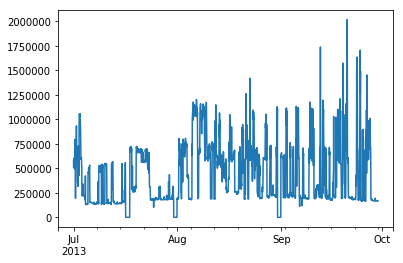

In [297]:
time_series[0].plot()
plt.show()

In [298]:
# HOLD OUT DATA

In [299]:
time_series_holdout = []
time_series_holdout.append(pd.Series(data= result_holdout['target'], index=index))

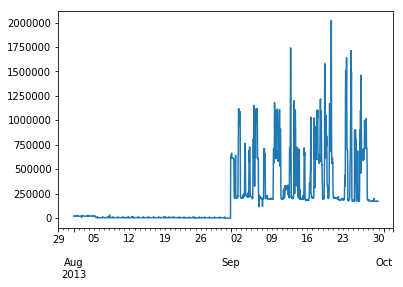

In [300]:
time_series_holdout[0].plot()
plt.show()

In [301]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))


In [302]:
with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

In [303]:
with s3filesystem.open(s3_data_path + "/holdout/houldout.json", 'wb') as fp:
    for ts in time_series_holdout:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

In [304]:
s3_data_path

'sagemaker-testtimeseries/sagemaker/test-demo-deepar/data'

In [305]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='test-demo-deepar',
    output_path="s3://" + s3_output_path
)

In [307]:
# student t under estimates with these parameters, tuned from an earlier job
hyperparameters  = {
    "time_freq": freq,
    "context_length": context_length,
    "prediction_length": prediction_length,
    "num_cells": "48",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [308]:
estimator.set_hyperparameters(**hyperparameters)

In [309]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: test-demo-deepar-2018-06-20-03-51-22-345


...................
Arguments: train
[06/20/2018 03:54:26 INFO 140039134000960] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'dropout_rate': u'0.10', u'cardinality': u'', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'mini_batch_size': u'32', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[06/20/2018 03:54:26 INFO 140039134000960] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'dropout_rate': u'0.05', u'learning_rate': u'0.001', u'num_cells': u'48', u'prediction_length': u'48', u'epochs': u'20', u'time_freq': u'H', u'context_length': u'24', u'num_layers': u'3', u'mini_batch_size': u'32', u'likelihood': u'gaussian', u'early_stopping_patience': u'10'}


[06/20/2018 03:54:40 INFO 140039134000960] Epoch[11] Batch[5] avg_epoch_loss=13.562003
[06/20/2018 03:54:40 INFO 140039134000960] Epoch[11] Batch [5]#011Speed: 316.47 samples/sec#011loss=13.562003
[06/20/2018 03:54:40 INFO 140039134000960] processed a total of 306 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1003.5579204559326, "sum": 1003.5579204559326, "min": 1003.5579204559326}}, "EndTime": 1529466880.483306, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529466879.466399}

[06/20/2018 03:54:40 INFO 140039134000960] #throughput_metric: host=algo-1, train throughput=304.879862147 records/second
[06/20/2018 03:54:40 INFO 140039134000960] #progress_metric: host=algo-1, completed 60 % of epochs
[06/20/2018 03:54:40 INFO 140039134000960] best epoch loss so far
[06/20/2018 03:54:40 INFO 140039134000960] Saved checkpoint to "/opt/ml/model/state_85fdaa80-6d02-4fd8-b9b0-584d3ed88f7e-0000.params"
#metrics {"Metrics": {"

#metrics {"Metrics": {"get_graph.time": {"count": 1, "max": 1816.169023513794, "sum": 1816.169023513794, "min": 1816.169023513794}}, "EndTime": 1529466891.062454, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529466889.245936}

[06/20/2018 03:54:52 INFO 140039134000960] Number of GPUs being used: 0
#metrics {"Metrics": {"finalize.time": {"count": 1, "max": 3564.677953720093, "sum": 3564.677953720093, "min": 3564.677953720093}}, "EndTime": 1529466892.810938, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529466891.062519}

[06/20/2018 03:54:52 INFO 140039134000960] Serializing to /opt/ml/model/model_algo-1
[06/20/2018 03:54:53 INFO 140039134000960] Saved checkpoint to "/opt/ml/model/model_algo-1-0000.params"
#metrics {"Metrics": {"model.serialize.time": {"count": 1, "max": 274.03998374938965, "sum": 274.03998374938965, "min": 274.03998374938965}}, "EndTime": 1529466893.085099, "Dim

Create endpoint and predictor
Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

Note: remember to delete the enpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [310]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: test-demo-deepar-2018-06-20-03-51-22-345
INFO:sagemaker:Creating endpoint-config with name test-demo-deepar-2018-06-20-03-51-22-345
INFO:sagemaker:Creating endpoint with name test-demo-deepar-2018-06-20-03-51-22-345


--------------------------------------------------------------------------!

In [311]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [312]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

In [313]:
#traindat = pd.Series(traindat)

In [314]:
list_of_df  = predictor.predict(time_series_training)
actual_data = time_series

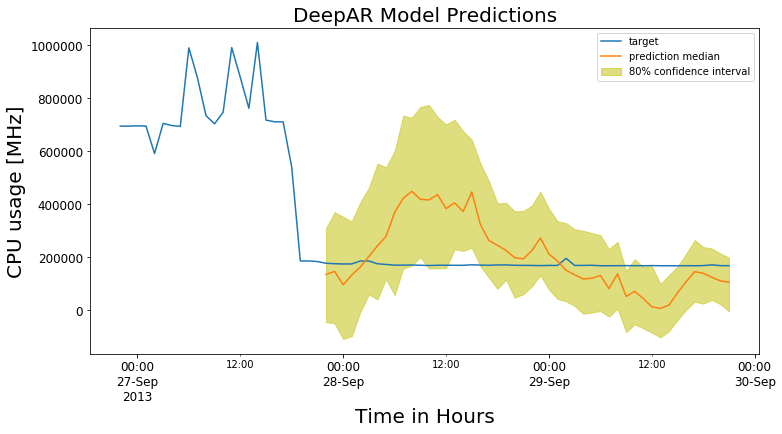

In [327]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.title("DeepAR Model Predictions", fontsize = 20)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
    plt.xlabel("Time in Hours", fontsize = 20)
    plt.yticks(fontsize=12);
    plt.xticks(fontsize=12);
    plt.legend()
    plt.show()

In [316]:
### Trying to evaluate model with commands

In [187]:
job_name = estimator.latest_training_job.name



predictor = sagemaker.predictor.RealTimePredictor(
    endpoint_name, 
    sagemaker_session=sagemaker_session, 
    content_type="application/json")

In [197]:

q1 = '0.1'         # compute p10 quantile
q2 = '0.9'         # compute p90 quantile
num_samples = 100  # predict 100 sample series
    
def buildPredictionData(year, data):
    year_temps = data[str(year)]
    s = {"start": "2013-0{}-01 00:00:00".format(year), "target": year_temps}
    series = []
    series.append(s)
    configuration = {
        "output_types": ["mean", "quantiles", "samples"],
        "num_samples": num_samples,
        "quantiles": [q1, q2]
    }
    http_data = {
        "instances": series, 
        "configuration": configuration
    }
    return json.dumps(http_data)

In [198]:
def getPredictedSeries(result):
    import random
    json_result = json.loads(result)
    y_data      = json_result['predictions'][0]
    y_mean      = y_data['mean']
    y_q1        = y_data['quantiles'][q1]
    y_q2        = y_data['quantiles'][q2]
    y_sample    = y_data['samples'][random.randint(0, num_samples)]
    return y_mean, y_q1, y_q2, y_sample

In [199]:

def plotSeries(result, truth=False, truth_data=None, truth_label=None):
    x = range(0,prediction_length)
    y_mean, y_q1, y_q2, y_sample = getPredictedSeries(result)
    plt.gcf().clear()
    mean_label,   = plt.plot(x, y_mean, label='mean')
    q1_label,     = plt.plot(x, y_q1, label=q1)
    q2_label,     = plt.plot(x, y_q2, label=q2)
    sample_label, = plt.plot(x, y_sample, label='sample')

    if truth:
        ground_truth, = plt.plot(x, truth_data, label=truth_label)
        plt.legend(handles=[ground_truth, q2_label, mean_label, q1_label, sample_label])
    else:
        plt.legend(handles=[q2_label, mean_label, q1_label, sample_label])
    plt.yticks(np.arange(5.0, 12.0, 0.5))
    plt.show()

In [203]:
year = 7 

prediction_data = buildPredictionData(year,time_series_training )
print(prediction_data)

result = predictor.predict(prediction_data).encode('utf-8')

plotSeries(result, 
           truth=True, 
           truth_data=testSet[str(year)][-prediction_length:], 
           truth_label='truth')

TypeError: list indices must be integers or slices, not str

## Created hyperparameter tuning job on the GUI, but attempting to do with code below.

In [ ]:
s3_input_train = 's3://{}/{}/train'.format(bucket, prefix)
s3_input_validation ='s3://{}/{}/holdout/'.format(bucket, prefix)

In [704]:
smclient = boto3.Session().client('sagemaker')

In [705]:
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                            HyperParameterTuningJobConfig = tuning_job_config,
                                            TrainingJobDefinition = training_job_definition)


NameError: name 'tuning_job_name' is not defined

### Query a trained model by using the model's endpoint. The endpoint takes the following JSON request format.

In [ ]:

{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0], "cat": 0},
  { "start": "2012-01-30", "target": [1.0], "cat": 2 },
  { "start": "1999-01-30", "target": [2.0, 1.0], "cat": 1 }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["mean", "quantiles", "samples"],
  "quantiles": ["0.5", "0.9"]
 }
}

In [128]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: test-demo-deepar-2018-06-19-17-29-48-394
